# Predicting Gene Ontology Enrichment of Cancer Microarray Datasets Using Machine Learning

## BMES 483/543 Final Project

**Authors:** [Ethan Jacob Moyer](mailto:ejm374@drexel.edu), [Ifeanyi Osuchukwu](mailto:imo27@drexel.edu), [Tony Kabilan Okeke](mailto:tko35@drexel.edu)

In [1]:
# Import modules
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from itertools import compress

import pandas as pd
import dataprep
import pickle
import tools
import os


# Path to data files
datapath = tools.get_data_path()

### Data Selection and Preparation

We originally selected a total of 21 Datasets, all of which contain 2 groups - 
a normal (healthy) group and a cancer group; all the datasets were generated on 
the GPL570 microarray.

The differentially expressed genes were identified in each of the datasets,
and a hypergeometric test was used to identify enriched Gene Ontology terms
in each dataset. One of the selected datasets was excluded because no
significantly differentially expressed genes were found, so a total of 20 
datasets were included in further analyses. The selected datasets are stored in 
[this](../selected_datasets.tsv) file.

The enriched GO terms from each dataset were combined into a single table, and
duplicate GO terms were excluded. To improve the performance of our model,
only GO terms present in between 45% and 55% of the datasets were included in
further analysis. We also filtered out highly correlated (r > 0.9) GO terms, 
leaving us with 22 Gene Ontology terms to predict.

In [43]:
# Load ML data
file = f"{datapath}/mldata.pkl"
if os.path.exists(file) and os.stat(file).st_size != 0:
    df, go_table = pd.read_pickle(file)
else:
    df, go_table = dataprep.main(datapath)

# Summarize cancer types in dataset
tbl1 = pd.read_table('results/selected_datasets.tsv')['Type'] \
    .value_counts().to_frame().reset_index() \
    .rename({'index': 'Cancer Type', 'Type': '# Data sets'}, axis=1)
tbl1.to_csv('results/table1-cancer-counts.tsv', sep='\t', index=False)
tbl1

,Cancer Type,# Data sets
0,Prostate,3
1,Lung,3
2,Colorectal,3
3,Breast,2
4,Head/Neck,2
5,Renal,2
6,Gastric,2
7,Pancreatic,1
8,Liver,1
9,Leukemia,1


In [3]:
# Filter out GO terms

## Keep only GO terms that occur in between 45% and 55% of datasets
go_range = go_table.apply(lambda x: sum(x) / len(x) <= 0.55 and sum(x) / len(x) >= 0.45)
go_table_filter = go_table.loc[:, go_range]

## Filter out GO terms that are highly correlated
corr_threshold = 0.9
skip, keep = [], []
for i, col_i in enumerate(go_table_filter):
    for j, col_j in enumerate(go_table_filter):
        if j <= i:
            continue
        if not col_j in skip:
            corr = go_table_filter[col_i].corr(go_table_filter[col_j])
            if abs(corr) > corr_threshold:
                skip.append(col_j)
            else:
                keep.append(col_i)
                
go_table_filter = go_table_filter.loc[:, go_table_filter.columns.isin(keep)]

### GO Term Prediction

#### Model Accuracy Before Feature Selection

Here, we evaluated the performance of the Logistic Regression classifier in
predicting Gene Ontology terms using all 34,524 genes (features).

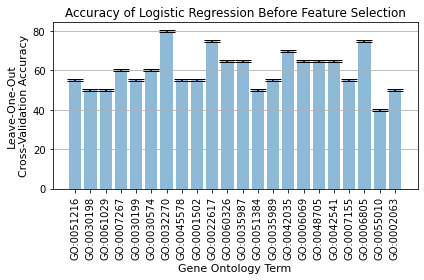

In [4]:
loo = LeaveOneOut()
clf = LogisticRegression(solver='sag', n_jobs=-1, max_iter=1500)

X = StandardScaler().fit_transform(df.values)
Y = go_table_filter.values

y_ran = go_table_filter.shape[1]
go_acc = {}
file_acc = f"{datapath}/go_acc.pkl"

if os.path.exists(file_acc):
    with open(file_acc, "rb") as file:
        go_acc = pickle.load(file)
else:
    for j in range(y_ran):
        y = Y[:,j]
        accuracy, std = tools.eval(X,y)
        go_acc[f'{go_table_filter.columns[j]}'] = {'Accuracy':accuracy*100, 'Std': std}
        print(f"--- Leave-One-Out Cross-Validation Accuracy for {go_table_filter.columns[j]}: {accuracy*100:.1f}% (+/-{std:.1f})")
  
    with open(file_acc, 'wb') as file:
        pickle.dump(go_acc, file, protocol=pickle.HIGHEST_PROTOCOL)

# Visualize results
tools.accuracy_plot(
    go_acc, score='Accuracy', err='Std', xlab='Gene Ontology Term',
    ylab='Leave-One-Out\nCross-Validation Accuracy',
    title='Logistic Regression Evaluation Before Feature Selection',
    filename='results/2022065-logreg-before-feature-selection.png'
)

#### Feature Selection

We performed feature selection using the Extra Trees Classifier.

In [5]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, Y)

feat = clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)

X_new = model.transform(X)
features_ = list(compress(df.columns, model.get_support()))

#### Model Accuracy After Feature Selection

Next, we evaluated the performance of the Logistic Regression classifier in
predicting Gene Ontology terms using the 943 genes identified in the feature selection.

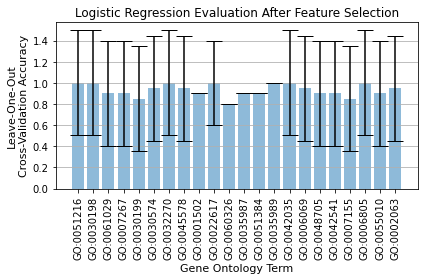

In [44]:
clf = LogisticRegression(solver='sag', n_jobs=-1, max_iter=1500)

X = StandardScaler().fit_transform(df[features_].values)  # Features
Y = go_table_filter.values  # GO terms

y_ran = go_table_filter.shape[1]  # Range of go terms columns

file_acc = f"{datapath}/go_fs.pkl"
go_fs = {}

if os.path.exists(file_acc):
    with open(file_acc, 'rb') as file:
        go_fs = pickle.load(file)
else:
    for target in range(y_ran):
        y = Y[:,target]
        selection = tools.forwardsel(clf, X, y)
        go_fs[f'{go_table_filter.columns[target]}'] = {'Score': selection[0], 
                                                       'Std': selection[1],
                                                       'Features': selection[2]}
        print(f"--- {go_table_filter.columns[target]} has completed Feature Selection ---")

    for go in go_fs.keys():
        idx = go_fs[go]['Features']
        genes = []
        for i in idx:
            genes.append(features_[i])
        go_fs[go]['Genes'] = genes
  
    with open(file_acc, 'wb') as file:
        pickle.dump(go_fs, file, protocol=pickle.HIGHEST_PROTOCOL)

# Visualize results
tools.accuracy_plot(
    go_fs, score='Score', err='Std', xlab='Gene Ontology Term',
    ylab='Leave-One-Out\nCross-Validation Accuracy',
    title='Logistic Regression Evaluation After Feature Selection',
    filename='results/2022065-logreg-after-feature-selection.png'
)

In [89]:
# Prepare table with selected genes
## Get GO term definitions
go_genes = {go: go_fs[go]['Genes'] for go in go_fs.keys()}
go_names = [tools.get_go_info(go)['name'] for go in go_genes]
go_names = [f'{name.capitalize()} ({go})' for name, go in zip(go_names, go_fs.keys())]

## Get gene symbols from GPL
gpl = tools.geodlparse('GPL570', geodir=datapath, quiet=False)
probe2gene = gpl.table.set_index('ID')['Gene Symbol'].to_dict()
genes = [', '.join([probe2gene[probe] for probe in sub]) for sub in go_genes.values()]

tbl2 = pd.DataFrame({'GO Term': go_names, 'Genes': genes})
tbl2.to_csv('results/table2-selected-genes.tsv', sep='\t', index=False)
tbl2

Loading cached data...


,GO Term,Genes
0,Cartilage development (GO:0051216),"ATP8B3, DEFB106A /// DEFB106B, PLA2G12A, COL6A5"
1,Extracellular matrix organization (GO:0030198),"TAF3, USP22, CACNB2"
2,Eyelid development in camera-type eye (GO:0061...,"KLHL12, APLP2"
3,Cell-cell signaling (GO:0007267),GNMT
4,Collagen fibril organization (GO:0030199),RAPGEF5
5,Collagen catabolic process (GO:0030574),RAPGEF5
6,Positive regulation of cellular protein metabo...,"WNT6, PSMD6, CTNNA1"
7,Negative regulation of b cell differentiation ...,"OLFM2, ACVR1B"
8,Cartilage condensation (GO:0001502),"CDHR3, FASTKD2"
9,Extracellular matrix disassembly (GO:0022617),"MYB, COL6A5, ADAMTSL1"
